In [2]:

import numpy as np
from nibabel.testing import data_path
import nibabel as nib

import keras
from keras import backend as K
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

import nilearn
from nilearn import plotting
from nilearn import image
from nilearn import datasets

from keras_tqdm import TQDMNotebookCallback

# Get dataset with nilearn function
# if not downloaded, will download. If already downloaded, will use local version
dataset = nilearn.datasets.fetch_cobre(n_subjects=146, data_dir="C:\\Users\\Imagi\\Documents\\5850\\datasets", url=None, verbose=1)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\npyio.py:2315: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [3]:
phenotypes = dataset["phenotypic"]
file_paths = dataset["func"]
phenotypes.sort(0) #sort by column corresponding to patient number
file_paths.sort() #sort file names by alphabetical order, which will result in sorting by patient number
#display(phenotypes[0])
#display(file_paths[0])

#file_paths is now a regular python list of the file paths to the fmri scans
#phenotypes is now a np.recarray of np.records storing patient info
# get just the diagnosis information from the phenotypes
diagnosis = phenotypes['diagnosis']
diagnosis_converted = []
#this stem is necessary to convert np.byte array into strings, 
#and then fit those strings into 2 categories:
#Schizophrenia or no Schizophrenia
for item in diagnosis:
    s = item.decode('UTF-8')
    if s != "None":
        diagnosis_converted.append(float(1))   #person has schizophrenia
    else:
        diagnosis_converted.append(float(0))   #person doesn't have schizophrenia

del diagnosis_converted[74] # item 74 is a messed up scan with different dimensions
del file_paths[74]                           # so it needs to be removed

y_train = np.array(diagnosis_converted)
y_train = keras.utils.to_categorical(y_train, len(np.unique(y_train))) #one hot encoding

# Make x train from the file paths
scans = []
for item in file_paths:
    scan = nib.load(item)
    data = scan.get_fdata()
    scans.append(data)
x_train = np.array(scans)
display(x_train.shape)
display(y_train.shape)

(145, 27, 32, 26, 150)

(145, 2)

In [4]:
meanarray = np.mean(x_train, axis=4)
display(meanarray.shape)
smallx_train = meanarray[0:10, :, :, :]
display(smallx_train.shape)
smallx_train = smallx_train.astype('float32').reshape(smallx_train.shape+(1,))
display(smallx_train.shape)
mnar2 = meanarray.astype('float32').reshape(meanarray.shape+(1,))
display(mnar2.shape)

(145, 27, 32, 26)

(10, 27, 32, 26)

(10, 27, 32, 26, 1)

(145, 27, 32, 26, 1)

In [5]:
#time to finally build a model and test it!
model1 = keras.Sequential()
model1.add(keras.layers.Conv3D(64, kernel_size = (2,2,2), activation = 'relu'
                              ,input_shape=[27,32,26,1]))

model1.add(keras.layers.Conv3D(128, (8,8,8), activation='relu'))
model1.add(keras.layers.MaxPooling3D(pool_size=(2,2,2)))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dropout(0.2))
model1.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 26, 31, 25, 64)    576       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 24, 18, 128)   4194432   
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 9, 12, 9, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 12, 9, 128)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 124416)            0         
_________________________________________________________________
dense_1 (Dense)      

In [6]:
#model1.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


batch_size = 10
epochs = 100
validation_split = 0.35
display("running...")

history = model1.fit(mnar2, y_train, 
                     batch_size = batch_size, epochs = epochs, verbose = 0, 
                     validation_split = validation_split, callbacks=[TQDMNotebookCallback()])

print("Finished")
print('Accuracy:',model1.evaluate(mnar2,y_train)[1]*100.0,'%')

'running...'

Instructions for updating:
Use tf.cast instead.



Finished
145/145 [==============================] - 173s 1s/step
Accuracy: 50.344827688973524 %


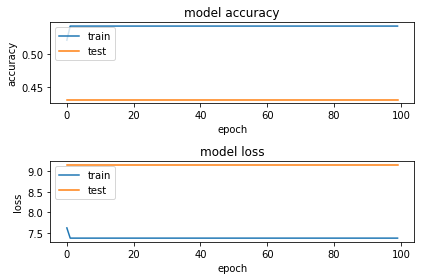

In [7]:
plt.figure()
plt.subplot(211)

#summarize accuracy history
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')

#summarize loss history
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')


plt.tight_layout()
plt.show()

## Evaluation
This network is the most simple, and I feel as though I understand it the best. It simply takes in the cobre data in all it's glory and throws it at the network. No preprocessing at all. Needless to say, it takes a while to train, but I also spent quite a lot of time with this network just trying to get the initial IT issues squared away. After that, I spent about 12-16 hours training it, and clearly used way too many epochs. It has one of the best accuracies, though, even if it really didn't "learn" all that well.

*In hindsight this is because I may have completely messed up the testing phase with the first two networks*